## Data Science Test

Please review all cells, following instructions for each and adding code and explaining your approach where appropriate.

The goal of this test is to observe your problem solving and the quality of your code, rather than looking for a particular single answer/solution.


April 2024

### Investigating  Data

# You will be using the apple mobility data set that should have been attached as a zipped csv along with this test.

In [5]:
# Loading necessary libraries
import os
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.utils import plot_windows
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.split import temporal_train_test_split, ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanSquaredError
warnings.filterwarnings(action='ignore', category=FutureWarning, module='seaborn')

## Part 1: Read in the raw data, and filter out all but Denmark and Norway.

In [7]:
raw_data = pd.read_csv(filepath_or_buffer=os.listdir()[1], low_memory=False)
raw_data.head()

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2022-02-15,2022-02-16,2022-02-17,2022-02-18,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,...,156.04,159.59,158.80,173.06,196.42,179.48,163.30,155.11,155.52,165.68
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,...,185.16,171.73,198.46,216.12,210.41,159.66,201.41,188.36,205.25,208.44
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,...,114.10,116.78,119.40,142.49,148.51,99.60,108.15,110.96,116.21,119.52
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,...,119.62,126.77,133.51,151.40,132.82,83.20,121.40,128.47,133.02,123.65
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,...,131.07,134.70,146.48,145.41,121.64,129.18,130.65,132.81,133.67,145.25


### Understanding the basic structure of the data

In [9]:
print(f'Number of rows: {raw_data.shape[0]} and number of columns {raw_data.shape[1]}')

Number of rows: 4691 and number of columns 780


In [10]:
raw_data['country'].unique()

array([nan, 'Germany', 'Australia', 'United States', 'Netherlands',
       'Turkey', 'Belgium', 'Greece', 'New Zealand', 'India', 'Thailand',
       'Spain', 'Switzerland', 'United Kingdom', 'Brazil', 'Italy',
       'France', 'Romania', 'Hungary', 'Argentina', 'Egypt', 'Canada',
       'South Africa', 'Morocco', 'Taiwan', 'Denmark', 'Indonesia',
       'United Arab Emirates', 'Ireland', 'Japan', 'Poland', 'Sweden',
       'Austria', 'Mexico', 'Vietnam', 'Finland', 'Malaysia', 'Russia',
       'Portugal', 'Philippines', 'Norway', 'Czech Republic',
       'Saudi Arabia', 'Chile', 'Republic of Korea', 'Israel', 'Slovakia',
       'Luxembourg'], dtype=object)

In [11]:
print('Geographical Division for data is according to the following:', raw_data['geo_type'].unique())

Geographical Division for data is according to the following: ['country/region' 'city' 'sub-region' 'county']


In [12]:
print('Different categories of mobility data:', raw_data['transportation_type'].unique())

Different categories of mobility data: ['driving' 'walking' 'transit']


In [13]:
def filter_country_data(df: pd.DataFrame, country_ls: list):

    '''
    ------ INPUT -------
    df: Dataframe containing data for filtering
    country_ls: List containing name of countries to be filtered

    ------ OUTPUT --------
    complete_df: Dataframe containing filtered countries and dates with complete data
    '''

    raw_df = df.copy(deep=True)
    country_df = raw_df[(raw_df['country'].isin(country_ls))].copy(deep=True)
    missing_cols = country_df.iloc[:, 6:].columns[country_df.iloc[:, 6:].isna().any()]
    print('Data missing for following dates:', list(missing_cols))
    complete_df = country_df.drop(missing_cols, axis=1)

    return complete_df

In [14]:
nordic_data = filter_country_data(df=raw_data, country_ls=['Denmark', 'Norway'])
nordic_data.head()

Data missing for following dates: ['2020-05-11', '2020-05-12', '2021-03-12']


,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2022-02-15,2022-02-16,2022-02-17,2022-02-18,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24
323,city,Copenhagen,driving,København,Capital Region of Denmark,Denmark,100.0,103.18,106.19,104.64,...,119.42,121.09,119.24,122.64,109.96,115.27,123.52,129.10,131.82,131.16
324,city,Copenhagen,transit,København,Capital Region of Denmark,Denmark,100.0,98.03,96.54,100.90,...,150.64,156.63,159.87,165.55,167.16,153.45,151.20,156.86,160.20,159.06
325,city,Copenhagen,walking,København,Capital Region of Denmark,Denmark,100.0,99.48,106.96,109.75,...,130.64,121.40,136.66,151.90,156.53,109.98,110.12,131.52,139.24,139.58
680,city,Oslo,driving,NaN,NaN,Norway,100.0,99.79,105.32,110.01,...,116.04,118.82,122.51,140.45,125.40,105.31,106.16,108.50,111.05,109.62
681,city,Oslo,transit,NaN,NaN,Norway,100.0,107.10,106.79,114.41,...,164.93,172.07,172.58,187.62,201.26,143.83,154.55,155.87,157.13,160.48


In [15]:
nordic_data.shape

(40, 777)

In [16]:
def prepare_pivot_data(df: pd.DataFrame):

    '''
    ------- INPUT --------
    df: Dataframe containing raw data to undergo cleaning process

    ------- OUTPUT -------
    clean_data: Dataframe in long format with datetime index
    '''

    raw_df = df.copy(deep=True)
    clean_data = pd.DataFrame()

    raw_df = raw_df.fillna('Missing')

    for row in raw_df.iterrows():

        geography_type = row[1]['geo_type']
        region = row[1]['region']
        transportation_kind = row[1]['transportation_type']
        other_name = row[1]['alternative_name']
        sub_reg = row[1]['sub-region']
        country = row[1]['country']

        ts_data = raw_df[(raw_df['geo_type'] == geography_type) &
                        (raw_df['region'] == region) &
                        (raw_df['transportation_type'] == transportation_kind) &
                        (raw_df['alternative_name'] == other_name) &
                        (raw_df['sub-region'] == sub_reg) &
                        (raw_df['country'] == country)].T

        ts_data = ts_data.iloc[6:]
        col_name = ts_data.columns[0]
        ts_data = ts_data[[col_name]]
        ts_data = ts_data.rename(columns={col_name: 'Mobility'})
        ts_data['Mobility'] = ts_data['Mobility'].astype('float')

        ts_data['Country'] = country
        ts_data['Geo_Type'] = geography_type
        ts_data['Region'] = region
        ts_data['Sub_Region'] = sub_reg
        ts_data['Alternative_Name'] = other_name
        ts_data['Transportation_Type'] = transportation_kind

        ts_data = ts_data.reset_index()
        ts_data = ts_data.rename(columns={'index': 'Date'})
        ts_data['Date'] = pd.to_datetime(ts_data['Date'])
        ts_data = ts_data.set_index('Date')

        clean_data = pd.concat([clean_data, ts_data], axis=0)

    return clean_data

In [17]:
nordic_clean_data = prepare_pivot_data(df=nordic_data)
nordic_clean_data.head()

,Mobility,Country,Geo_Type,Region,Sub_Region,Alternative_Name,Transportation_Type
Date,,,,,,,
2020-01-13,100.00,Denmark,city,Copenhagen,Capital Region of Denmark,København,driving
2020-01-14,103.18,Denmark,city,Copenhagen,Capital Region of Denmark,København,driving
2020-01-15,106.19,Denmark,city,Copenhagen,Capital Region of Denmark,København,driving
2020-01-16,104.64,Denmark,city,Copenhagen,Capital Region of Denmark,København,driving
2020-01-17,109.86,Denmark,city,Copenhagen,Capital Region of Denmark,København,driving


In [18]:
def resample_country_data(df: pd.DataFrame, frequency: str, resampling_variable: list, grouping_variable: list, add_wow_chg: bool):

    '''
    -------- INPUT --------
    df: Dataframe in long format with datetime index
    frequency: String representing resampling frequency for data
    resampling_variable: List containing the string representing the name of the variable to be resampled
    grouping_variable: List containing the string representing the name of the variables to be used for grouping
    add_wow_chg: Bool representing whether to add Week-on-Week percentage change

    ------- OUTPUT --------
    resampled_data: Dataframe containing resampled data as per the specified frequency
    '''

    all_variables = resampling_variable + grouping_variable

    resampling_data = df[all_variables].copy(deep=True)

    resampled_data = (resampling_data
                        .groupby(grouping_variable)[resampling_variable[0]]
                        .resample(frequency)
                        .mean(numeric_only=True).
                        reset_index()
                        .set_index('Date'))

    if add_wow_chg:

        resampled_data['WoW_Mobility_Change'] = (resampled_data
                                                .groupby(grouping_variable)[resampling_variable[0]]
                                                .pct_change()*100)

    return resampled_data

## Part 2: Resample the time series data to weekly granularity, and determine if you think mobility between the two countries are correlated or not.

In [20]:
nordic_weekly_resampled_df = resample_country_data(df=nordic_clean_data,
                                                  frequency='W',
                                                  resampling_variable=['Mobility'],
                                                  grouping_variable=['Country', 'Transportation_Type'],
                                                  add_wow_chg=True)
nordic_weekly_resampled_df.head()

,Country,Transportation_Type,Mobility,WoW_Mobility_Change
Date,,,,
2020-01-19,Denmark,driving,104.869524,NaN
2020-01-26,Denmark,driving,105.809762,0.896579
2020-02-02,Denmark,driving,109.354048,3.349677
2020-02-09,Denmark,driving,106.801905,-2.333835
2020-02-16,Denmark,driving,107.938333,1.064053


In [21]:
dnk_ts = nordic_weekly_resampled_df[(nordic_weekly_resampled_df['Country'] == 'Denmark')][['Mobility']]
nor_ts = nordic_weekly_resampled_df[(nordic_weekly_resampled_df['Country'] == 'Norway')][['Mobility']]

## Part 3: Briefly explain your conclusion about mobility correlation

### Now, we choose spearman rank correlation to assess the monotonic relation between mobility levels in Denmark and Norway. It is quite evident that the mobility levels in Denmark and Norway is significantly high. 

#### This can be accounted due to following reasons:
1. Socio-economic status of both the nordic countries is at par with each other, thus allowing similar levels of mobility trends
2. Well connected public transport systems allowing easier mobility routes
3. Safe means of transit offered within different transportation mechnanisms

In [24]:
print('Spearman Correlation Coefficient between Mobility levels in Denmark and Norway:', 
      dnk_ts['Mobility'].corr(nor_ts['Mobility'], method='spearman'))

Spearman Correlation Coefficient between Mobility levels in Denmark and Norway: 0.9411739854709338


## Part 4: Take your weekly resampled data for both countries, and plot it broken up into the three types of mobility. Now add week-on-week changes to the plot, using a 2nd axis. Also include the results of your correlation investigation in the previous cell.

In [26]:
def create_mobility_plots(plotting_df: pd.DataFrame):

    '''
    -------- INPUT ---------
    plotting_df: Dataframe containing the data for creating the plots

    ------- OUTPUT ---------
    Plot representing the comparison of mobility figures across different countries 
    split by the available transportation type 
    '''

    weekly_resampled_data = plotting_df.copy(deep=True)

    # Prepare for plotting
    countries = weekly_resampled_data['Country'].unique()
    transport_types = weekly_resampled_data['Transportation_Type'].unique()
    
    # Plot
    fig, axes = plt.subplots(len(transport_types), 1, figsize=(14, 12), sharex=True)
    
    for i, transport_type in enumerate(transport_types):
        ax1 = axes[i]
    
        for country in countries:
            df_plot = weekly_resampled_data[
                (weekly_resampled_data['Transportation_Type'] == transport_type) &
                (weekly_resampled_data['Country'] == country)
            ]
    
            ax1.plot(df_plot.index, df_plot['Mobility'], label=f'{country}', linewidth=2)
    
        ax1.set_ylabel('Mobility')
        ax1.set_title(f'{transport_type.title()} Mobility')
    
        # Secondary axis for WoW % change
        ax2 = ax1.twinx()
        for country in countries:
            df_plot = weekly_resampled_data[
                (weekly_resampled_data['Transportation_Type'] == transport_type) &
                (weekly_resampled_data['Country'] == country)
            ]
            ax2.plot(df_plot.index, df_plot['WoW_Mobility_Change'], linestyle='--', alpha=0.5)
    
        ax2.set_ylabel('WoW Change (%)', color='gray')
    
    axes[-1].set_xlabel('Date')
    axes[0].legend(title='Country', loc='upper left')
    plt.tight_layout()
    plt.show()

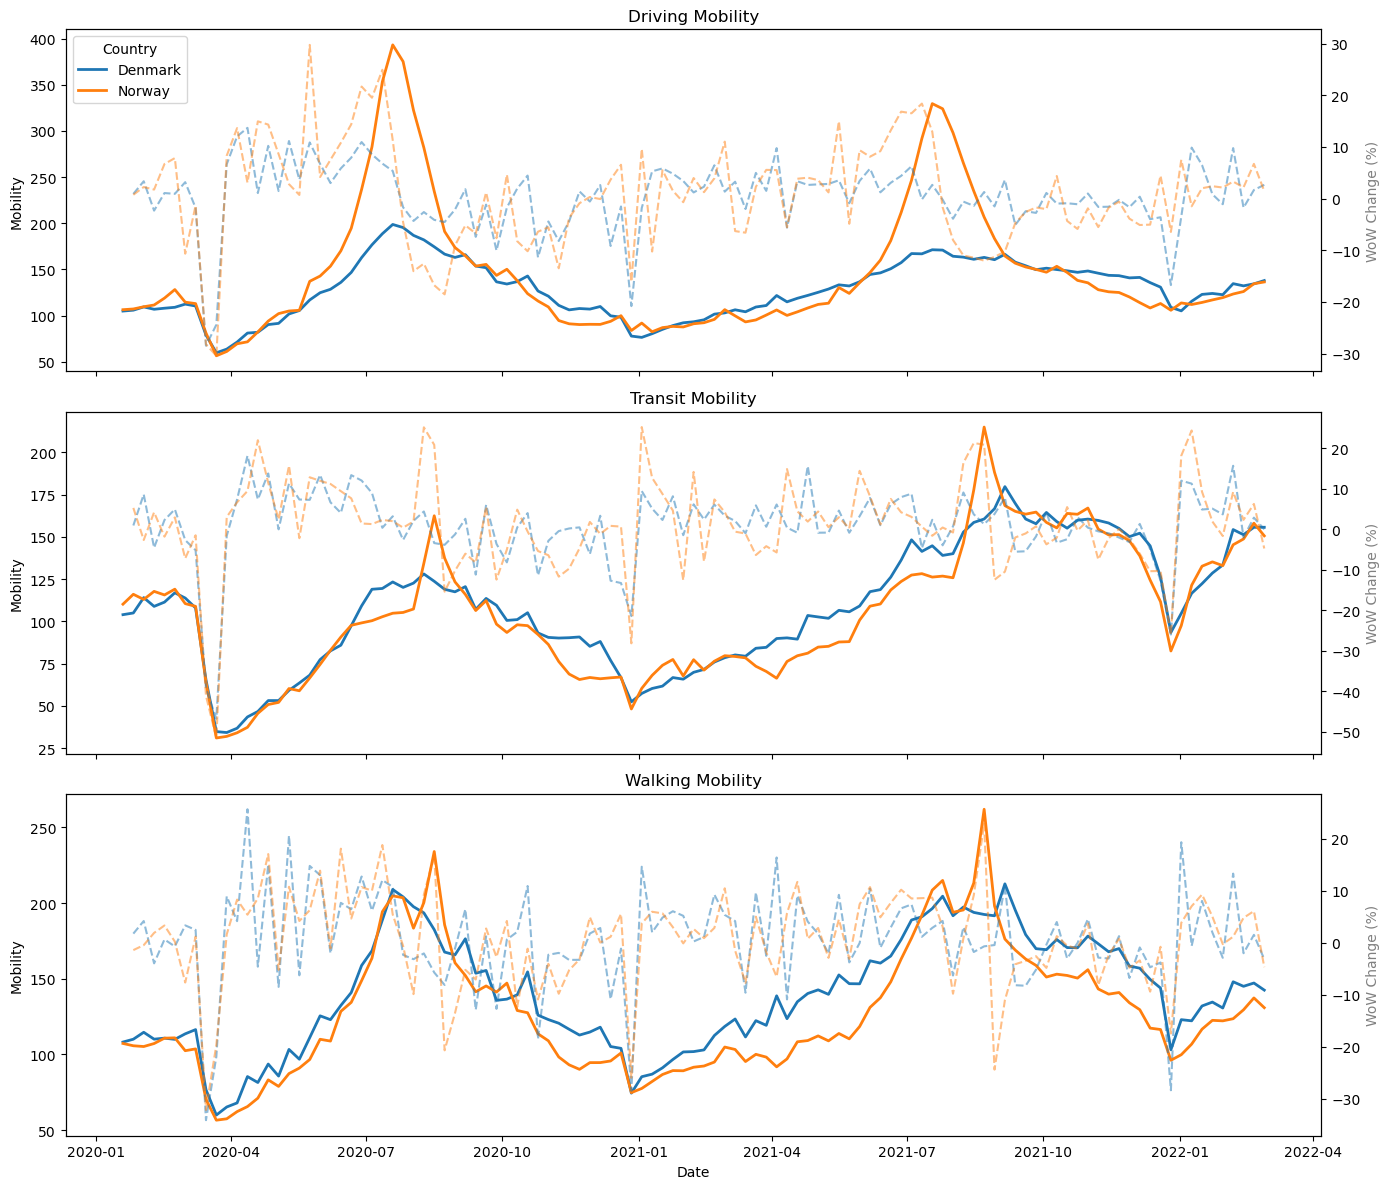

In [27]:
create_mobility_plots(plotting_df=nordic_weekly_resampled_df)

## Part 5: Repeat the above two exercises, but now for Italy and the United States. Comment briefly on the differences between the two correlation comparisons and what might cause them

In [29]:
us_it_df = filter_country_data(df=raw_data, country_ls=['United States', 'Italy'])
us_it_df.head()

Data missing for following dates: ['2020-05-11', '2020-05-12', '2021-03-12']


,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,...,2022-02-15,2022-02-16,2022-02-17,2022-02-18,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24
158,city,Akron,driving,NaN,Ohio,United States,100.0,103.06,107.50,106.14,...,146.04,157.25,153.04,175.20,164.49,129.31,156.26,148.16,150.89,151.68
159,city,Akron,transit,NaN,Ohio,United States,100.0,106.69,103.75,100.22,...,66.10,75.00,72.28,74.26,54.78,56.10,78.24,74.78,73.24,77.57
160,city,Akron,walking,NaN,Ohio,United States,100.0,97.23,79.05,74.77,...,100.46,104.06,115.74,131.04,126.98,90.60,119.36,111.19,101.37,105.14
161,city,Albany,driving,NaN,New York,United States,100.0,102.35,107.35,105.54,...,133.03,135.27,153.97,172.62,150.03,125.23,148.32,145.38,149.22,167.18
162,city,Albany,transit,NaN,New York,United States,100.0,100.14,105.95,107.76,...,146.59,145.66,174.22,179.05,148.26,125.92,170.41,168.79,161.03,163.17


In [30]:
us_it_clean_data = prepare_pivot_data(df=us_it_df)
us_it_clean_data.head()

,Mobility,Country,Geo_Type,Region,Sub_Region,Alternative_Name,Transportation_Type
Date,,,,,,,
2020-01-13,100.00,United States,city,Akron,Ohio,Missing,driving
2020-01-14,103.06,United States,city,Akron,Ohio,Missing,driving
2020-01-15,107.50,United States,city,Akron,Ohio,Missing,driving
2020-01-16,106.14,United States,city,Akron,Ohio,Missing,driving
2020-01-17,123.62,United States,city,Akron,Ohio,Missing,driving


In [31]:
us_it_weekly_resampled_df = resample_country_data(df=us_it_clean_data,
                                                 frequency='W',
                                                 resampling_variable=['Mobility'],
                                                 grouping_variable=['Country', 'Transportation_Type'],
                                                 add_wow_chg=True)
us_it_weekly_resampled_df.head()

,Country,Transportation_Type,Mobility,WoW_Mobility_Change
Date,,,,
2020-01-19,Italy,driving,109.941429,NaN
2020-01-26,Italy,driving,111.711381,1.609905
2020-02-02,Italy,driving,110.718762,-0.888557
2020-02-09,Italy,driving,112.631333,1.727414
2020-02-16,Italy,driving,124.726238,10.738490


In [32]:
us_ts = us_it_weekly_resampled_df[(us_it_weekly_resampled_df['Country'] == 'United States')][['Mobility']]
it_ts = us_it_weekly_resampled_df[(us_it_weekly_resampled_df['Country'] == 'Italy')][['Mobility']]

In [33]:
print('Spearman Correlation Coefficient between Mobility levels in United States and Italy:', 
      us_ts['Mobility'].corr(it_ts['Mobility'], method='spearman'))

Spearman Correlation Coefficient between Mobility levels in United States and Italy: 0.7711428331874187


### We observe that the spearman correlation coefficient for mobility levels in United States and Italy is comparatively lower than Denmark & Norway. 

#### This can be accounted due to following reasons:
1. Economic Disparity amongst the earning members of the society
2. Wide range of demographics constituting the functioning society of the United States when compared to Italy
3. Differences in the development levels across United States & Italy when compared with closely located and developed Denmark & Norway

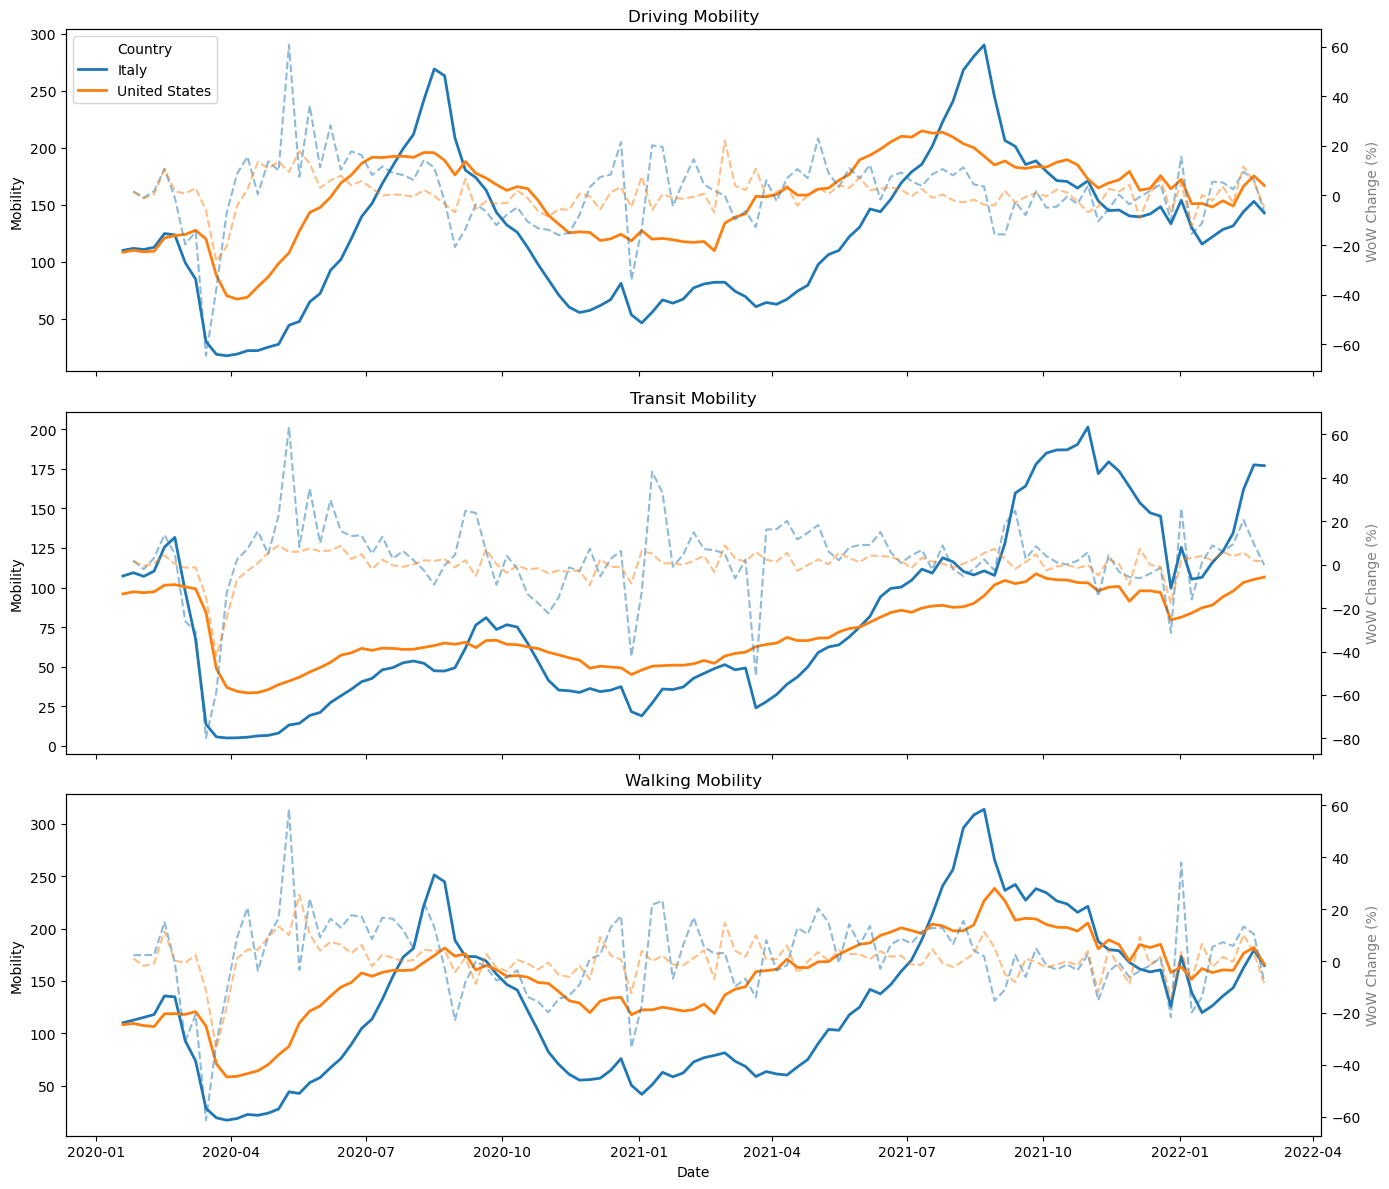

In [35]:
create_mobility_plots(plotting_df=us_it_weekly_resampled_df)

### Modelling with Data

## Part 6: Take the data from the United States, and prepare it for modelling... if any "choices" need to be made during the clean-up process, briefly describe the options and why you chose the one you did. Describe choices in the clean up step

In [38]:
us_model_data = (us_it_weekly_resampled_df[(us_it_weekly_resampled_df['Country'] == 'United States')]
                 [['Country', 'Transportation_Type', 'Mobility']].copy(deep=True))
us_model_data.head()

,Country,Transportation_Type,Mobility
Date,,,
2020-01-19,United States,driving,108.291680
2020-01-26,United States,driving,110.018809
2020-02-02,United States,driving,108.715792
2020-02-09,United States,driving,109.219251
2020-02-16,United States,driving,120.859832


In [39]:
us_model_data['Transportation_Type'].value_counts()

Transportation_Type
driving    111
transit    111
walking    111
Name: count, dtype: int64

In [40]:
us_clean_df = us_it_clean_data[(us_it_clean_data['Country'] == 'United States')].copy(deep=True)
us_clean_df.head()

,Mobility,Country,Geo_Type,Region,Sub_Region,Alternative_Name,Transportation_Type
Date,,,,,,,
2020-01-13,100.00,United States,city,Akron,Ohio,Missing,driving
2020-01-14,103.06,United States,city,Akron,Ohio,Missing,driving
2020-01-15,107.50,United States,city,Akron,Ohio,Missing,driving
2020-01-16,106.14,United States,city,Akron,Ohio,Missing,driving
2020-01-17,123.62,United States,city,Akron,Ohio,Missing,driving


### Here, we check whether any of the transportation type has no data across different Sub-Regions in the United States

In [42]:
for sub_reg, transit_type in itertools.product(us_clean_df['Sub_Region'].unique(), us_clean_df['Transportation_Type'].unique()):

    dp = us_clean_df[(us_clean_df['Sub_Region'] == sub_reg) & (us_clean_df['Transportation_Type'] == transit_type)].shape[0]

    if dp == 0:
        print(f'Length of data for {transit_type} in {sub_reg}: {dp}')

Length of data for transit in Alaska: 0
Length of data for transit in Idaho: 0
Length of data for transit in South Carolina: 0
Length of data for transit in Iowa: 0
Length of data for transit in Puerto Rico: 0
Length of data for transit in Kansas: 0
Length of data for transit in Mississippi: 0
Length of data for transit in Vermont: 0
Length of data for transit in Wyoming: 0
Length of data for walking in Wyoming: 0
Length of data for transit in Maine: 0
Length of data for transit in Arkansas: 0
Length of data for transit in Montana: 0
Length of data for transit in New Hampshire: 0
Length of data for transit in West Virginia: 0
Length of data for transit in South Dakota: 0
Length of data for walking in South Dakota: 0
Length of data for transit in North Dakota: 0
Length of data for transit in Guam: 0
Length of data for walking in Guam: 0
Length of data for transit in Virgin Islands: 0
Length of data for walking in Virgin Islands: 0


### Modelling Assumptions
1. We model the data on the Country Level for each Transportation Type as we can perform proper time-series cross validation
2. For preparing the model we will resample the data to weekly frequency and will try to forecast the next 4 weeks (month)
3. As the data for transit transportation type is inconsistent, there can be discrepancies in the Transit model for United States
4. We train our model in an interative fashion starting with first 52 weeks and validate it over subsequent 4 weeks. We repeat this until our whole training set gets exhausted. Also, we test the optimal parameters for our forecasting algorithm while maintaining the walk forward cross validation approach to prepare the optimal forecasting model
5. Once we obtain the best forecasting model, we forecast the next 4 weeks from the tail of our out-of-sample testing set comprising of 8 weeks after the end of our training period
6. In order to understand the walk-forward cross validation approach, we plot it for clear depiction of modelling methodology

In [44]:
def create_forecasting_model(random_seed: int, training_data_size: int, test_data_size: int,
                             expanding_training_size_length: int, forecast_horizon: int,
                             model_data: pd.DataFrame, parameter_grid, transport_type: str):

  '''
  -------- INPUT ----------
  random_seed: Integer for reproducibility of the results
  training_data_size: Integer representing size of data for training our forecasting algorithm
  test_data_size: Integer representing size of data for testing our forecasting algorithm
  expanding_training_size_length: Integer representing the size of points addded to extend training size for continuous chronological 
  evaluation for time series aware cross validation during training of forecasting algorithm
  forecast_horizon: Integer representing the forecasting horizon. Forecast is produced from the tail end of test_data_size
  model_data: Dataframe with datetime index containing the dependent variable
  parameter_grid: Dictionary representing the set of parameters to be tested for finding the optimal forecasting algorithm
  transport_type: String representing the transport kind for building the model

  --------- OUTPUT ----------
  results_df: Dataframe containing the results over the out-of-sample test set
  forecasting_model: Optimal model object trained and tested over the dataset
  cross_val_object: Optimal cross validation model object trained and tested over the dataset
  '''

  forecasting_model = AutoETS(auto=False, random_state=random_seed)
  y_train, y_test = temporal_train_test_split(y=model_data, test_size=test_data_size)
  ts_cv = ExpandingWindowSplitter(fh=range(1, test_data_size+1), initial_window=training_data_size,
                                  step_length=expanding_training_size_length)

  print(f'Building Model for {transport_type}')
  print(f'Training Set: {y_train.index.min()} - {y_train.index.max()}')
  print(f'Testing Set: {y_test.index.min()} - {y_test.index.max()}')
  
  plot_windows(ts_cv, y_train)

  smape = MeanAbsolutePercentageError(symmetric=False)
  rmse = MeanSquaredError(square_root=True)
  cross_val_object = ForecastingGridSearchCV(forecaster=forecasting_model,
                                           cv = ts_cv,
                                           param_grid=parameter_grid,
                                           scoring=rmse,
                                           n_jobs=-1,
                                           error_score='raise',
                                           verbose=1)

  cross_val_object.fit(y=y_train, fh=range(1, test_data_size+1))
  forecasting_model = cross_val_object.best_forecaster_

  forecast_df = (cross_val_object
                 .predict(fh=range(1, forecast_horizon+1))
                 .reset_index())

  forecast_df = forecast_df.rename(columns = {'index': 'Date'})
  forecast_df['Kind'] = 'Forecast'
  forecast_df.loc[:len(y_test)-1, 'Kind'] = 'Test Prediction'

  y_test_df = y_test.reset_index()
  y_test_df['Kind'] = 'Test Actual'

  results_df = pd.merge(left=forecast_df, right=y_test_df, how='outer')
  results_df['Mobility'] = results_df['Mobility'].astype(float)
  results_df['Transport_Type'] = transport_type
  results_df['Date'] = results_df['Date'].dt.to_timestamp()
  results_df = results_df.set_index('Date')

  return results_df, forecasting_model, cross_val_object

In [45]:
param_grids = {
    'error': ['add', 'mul'],
    'trend': ['add', 'mul'],
    'damped_trend': [True, False],
    'seasonal': ['add', 'mul'],
    'sp': [13, 26]
}     

Building Model for driving
Training Set: 2020-01-13/2020-01-19 - 2022-01-24/2022-01-30
Testing Set: 2022-01-31/2022-02-06 - 2022-02-21/2022-02-27
Fitting 52 folds for each of 32 candidates, totalling 1664 fits
Building Model for transit
Training Set: 2020-01-13/2020-01-19 - 2022-01-24/2022-01-30
Testing Set: 2022-01-31/2022-02-06 - 2022-02-21/2022-02-27
Fitting 52 folds for each of 32 candidates, totalling 1664 fits
Building Model for walking
Training Set: 2020-01-13/2020-01-19 - 2022-01-24/2022-01-30
Testing Set: 2022-01-31/2022-02-06 - 2022-02-21/2022-02-27
Fitting 52 folds for each of 32 candidates, totalling 1664 fits


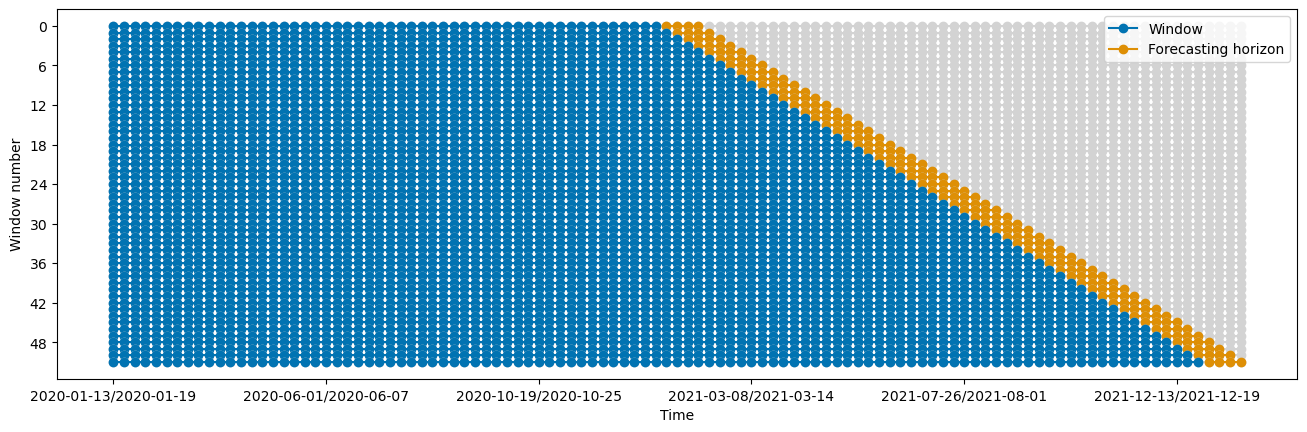

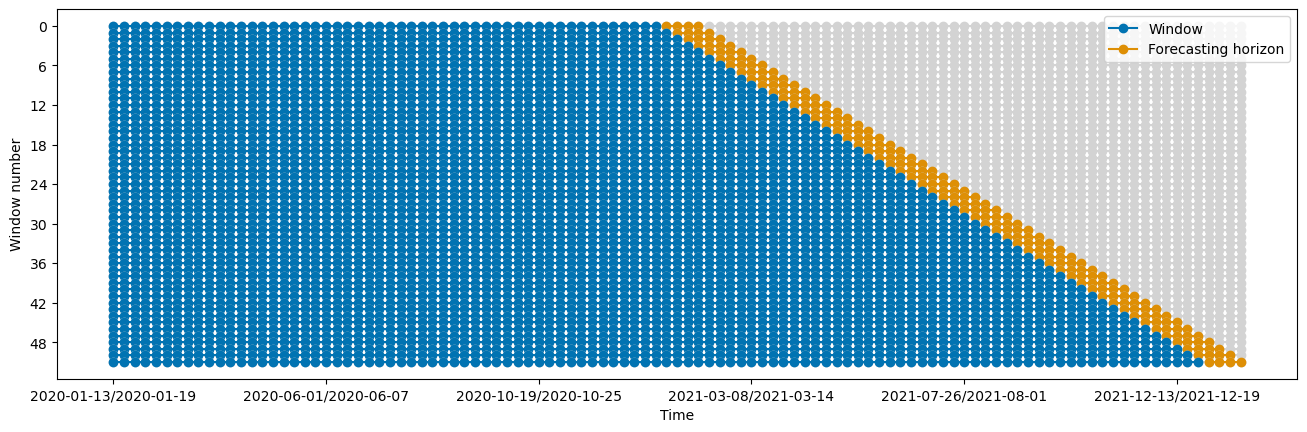

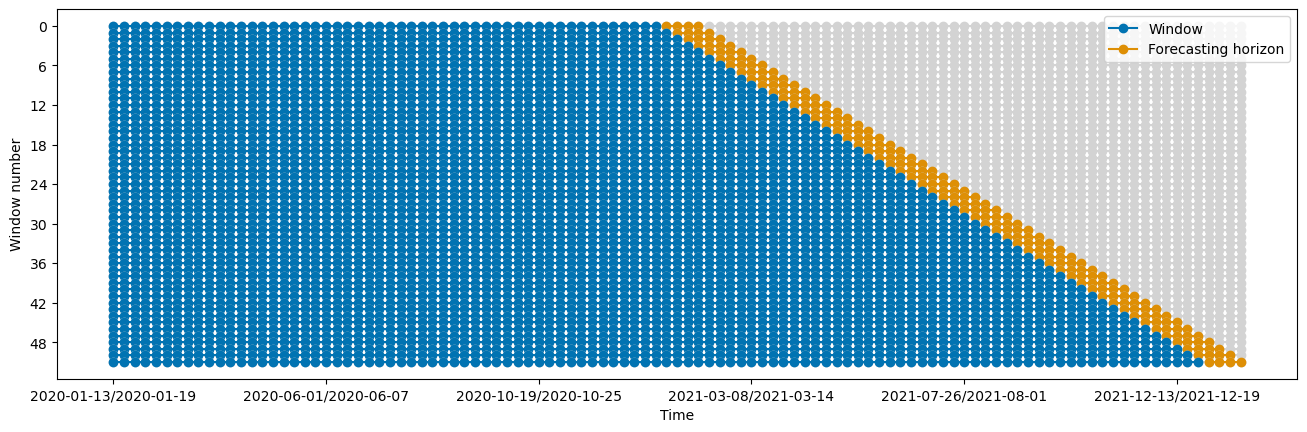

In [46]:
transit_error_metrics = []
transit_type = []
transit_country_df = pd.DataFrame()
model_dict = {}
for transport_type in ['driving', 'transit', 'walking']:

  mobility_data = us_model_data[(us_model_data['Transportation_Type'] == transport_type)][['Mobility']]
  mobility_data.index = mobility_data.index.to_period('W')
  rs = np.random.randint(low=1, high=1000000)

  results_df, forecasting_model, cross_val_object = create_forecasting_model(random_seed=rs,
                                      training_data_size=52,
                                      test_data_size=4,
                                      expanding_training_size_length=1,
                                      forecast_horizon=8,
                                      model_data=mobility_data,
                                      parameter_grid=param_grids,
                                      transport_type=transport_type
                                      )

  model_dict[transport_type] = forecasting_model
  y_test = results_df[(results_df['Kind'] == 'Test Actual')]['Mobility']
  y_pred = results_df[(results_df['Kind'] == 'Test Prediction')]['Mobility']

  results_df['Country'] = 'United States'

  rmse = MeanSquaredError(square_root=True)
  transit_error_metrics.append(rmse(y_true=y_test, y_pred=y_pred))
  transit_type.append(transport_type)
  transit_country_df = pd.concat([transit_country_df, results_df], axis=0)

transit_error_df = pd.DataFrame({'Country': 'United States',
                                 'Type': transit_type,
                                 'RMSE': transit_error_metrics})

In [47]:
transit_error_df

,Country,Type,RMSE
0,United States,driving,12.114903
1,United States,transit,7.160694
2,United States,walking,9.419491


In [48]:
model_dict

{'driving': AutoETS(random_state=427016, seasonal='mul', sp=13, trend='add'),
 'transit': AutoETS(error='mul', random_state=699688, seasonal='add', sp=13, trend='add'),
 'walking': AutoETS(damped_trend=True, random_state=673172, seasonal='add', sp=13,
         trend='add')}

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


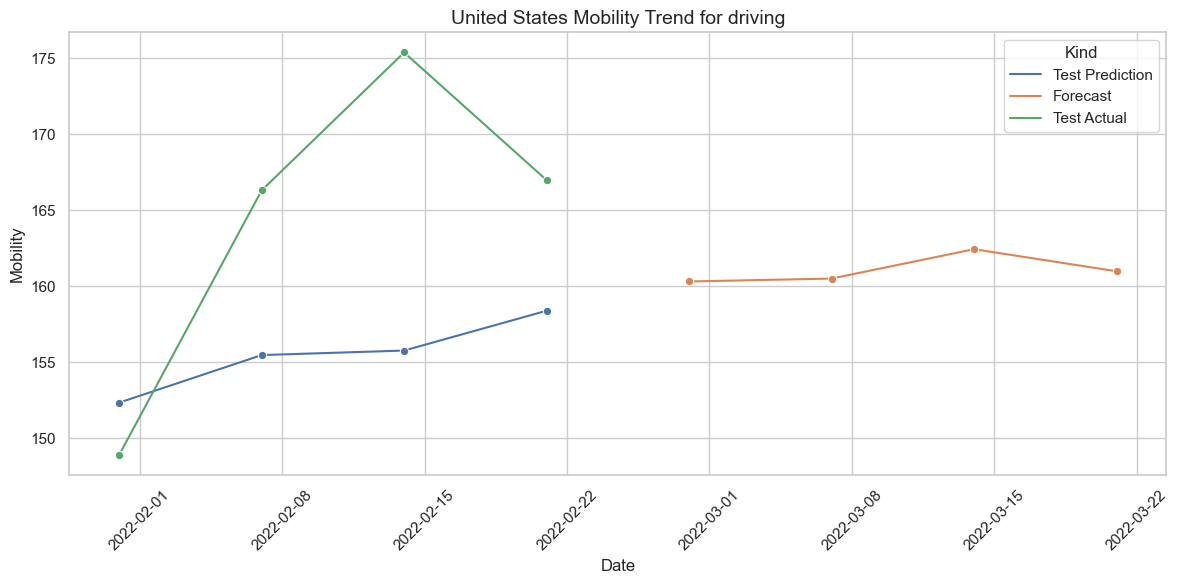

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


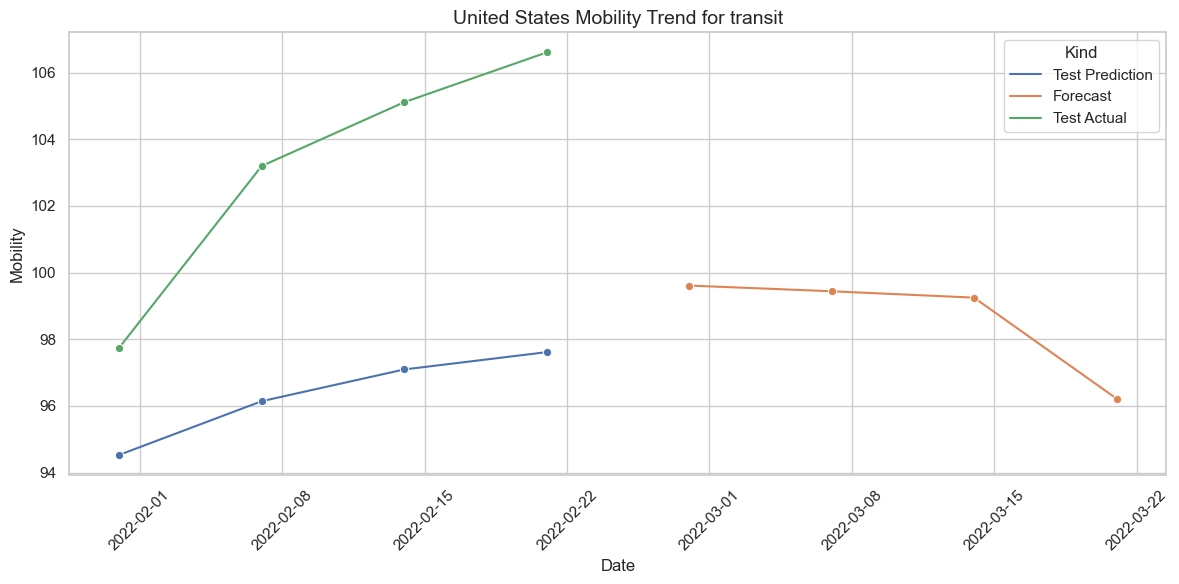

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


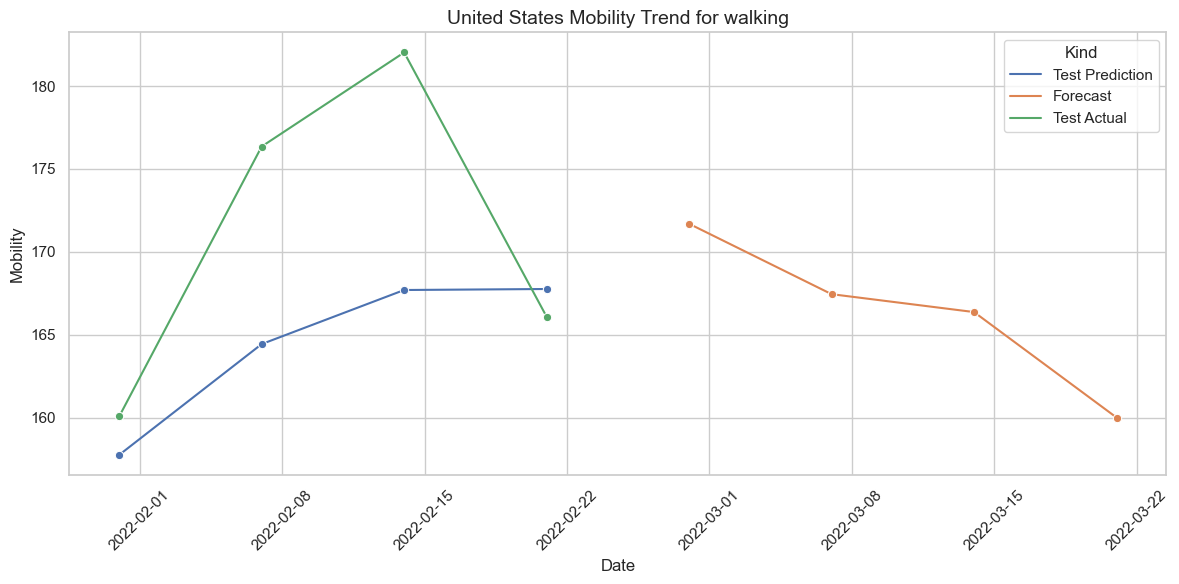

In [49]:
sns.set(style="whitegrid")

for transport_type in transit_country_df['Transport_Type'].unique():
    plot_transit_df = transit_country_df[transit_country_df['Transport_Type'] == transport_type]

    plt.figure(figsize=(12, 6))
    ax = sns.lineplot(
        data=plot_transit_df,
        x=plot_transit_df.index,
        y='Mobility',
        hue='Kind',
        marker='o'
    )

    ax.set_title(f"United States Mobility Trend for {transport_type}", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Mobility")
    plt.legend(title="Kind")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show();

## Part 7: Create a model that predicts the next week's average driving mobility in the US. Evaluate the accuracy of your model, and briefly discuss whether it is a "good" model or not. Add commentary on the quality of the model

In [51]:
transit_country_df[(transit_country_df['Kind'] == 'Forecast')]

,Mobility,Kind,Transport_Type,Country
Date,,,,
2022-02-28,160.306081,Forecast,driving,United States
2022-03-07,160.497954,Forecast,driving,United States
2022-03-14,162.428600,Forecast,driving,United States
2022-03-21,160.977851,Forecast,driving,United States
2022-02-28,99.611416,Forecast,transit,United States
2022-03-07,99.440222,Forecast,transit,United States
2022-03-14,99.249263,Forecast,transit,United States
2022-03-21,96.220689,Forecast,transit,United States
2022-02-28,171.698132,Forecast,walking,United States


### Model Results:
1. Our model shows is off by 12.11 mobility units for mobility via driving, 7.16 mobility units for transit and 9.42 mobility units for walking
2. Driving Forecast for Next Week: 160.31 Mobility Units
3. Transit Forecast for Next Week: 99.61 Mobility Units
4. Walking Forecast for Next Week: 171.69 Mobility Units
5. We expect out model to be robust as we have incorporated time series cross validation ensuring robust estimation of optimal parameters for the forecasting algorithm

### Scope of Improvements:
1. Availability of more granular data (At hourly, six-hourly frequency, etc.)
2. Modelling mobility as a function of other independent variables (Example: Temporal Patterns(Day of Week, Week of Year, Month of Year), Weather (Wind Speed, Temperature, Humidity, Precipitation, etc.), Economics (Fuel Price, Employment Rate, Public Transit Fare, etc.), Demographics (Avg. Income, Population Density, Avg. Age, etc.)
3. Experimenting with other Non-Parametric ML Algorithms (Ensemble Methods, Boosting Methods, etc.) that require significant data for determining optimal parameters for predictive algorithm